# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,NumericType,LongType,IntegerType
from pyspark.sql.functions import desc,asc,sum,mean,avg,max
import pyspark.sql.functions as F
from pyspark.sql.functions import col, row_number
import numpy as np
from sklearn.metrics import f1_score,accuracy_score
from pyspark.sql.functions import col, row_number, when
import seaborn as sns
from pyspark.ml.feature import StandardScaler, VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time
from pyspark.ml.stat import Correlation
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.driver.host', 'cddb82df6f15'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '36755'),
 ('spark.app.id', 'local-1672508961159'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
event_data = spark.read.json('mini_sparkify_event_data.json')

In [4]:
event_data.printSchema()
event_data.count()
print("the data subset has {} rows and {} columns ".format(event_data.count(), len(event_data.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

the data subset has 286500 rows and 18 columns 


In [5]:
#Null/Empty Check on every column in the dataframe (COMMENT IN LATER)
print({col:event_data.filter(event_data[col].isNull()).count() for col in event_data.columns})
print({col:event_data.filter(event_data[col] == '').count() for col in event_data.columns})
# in 8346 the userId is empty, and the following fields are null firstName, gender, lastName, userAgent
# verify assumption that this is a specific type of event
#event_data.select("*").where(event_data.userId == '').take(1000)
#event_data.filter((event_data.auth !='Logged Out') & (event_data.userId == '')).show()
#if the user is 'Logged Out' or a 'Guest' the records have no relevant information for us => drop them
event_data_cleaned = event_data.filter((event_data.auth != 'Logged Out') & (event_data.auth != 'Guest'))
print("The data subset has {} rows and {} columns ".format(event_data.count(), len(event_data.columns)))

{'artist': 58392, 'auth': 0, 'firstName': 8346, 'gender': 8346, 'itemInSession': 0, 'lastName': 8346, 'length': 58392, 'level': 0, 'location': 8346, 'method': 0, 'page': 0, 'registration': 8346, 'sessionId': 0, 'song': 58392, 'status': 0, 'ts': 0, 'userAgent': 8346, 'userId': 0}
{'artist': 0, 'auth': 0, 'firstName': 0, 'gender': 0, 'itemInSession': 0, 'lastName': 0, 'length': 0, 'level': 0, 'location': 0, 'method': 0, 'page': 0, 'registration': 0, 'sessionId': 0, 'song': 0, 'status': 0, 'ts': 0, 'userAgent': 0, 'userId': 8346}
The data subset has 286500 rows and 18 columns 


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.




In [6]:
#explore all possible event types
event_data.select("page").dropDuplicates().sort("page").show(100,truncate= False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|NextSong                 |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [7]:
#define churn
is_churn = udf(lambda x: int(x=="Cancellation Confirmation"))
event_data_cleaned = event_data_cleaned.withColumn("churn", is_churn("page").cast("integer"))
#partitionBy userId and add st every event by a user is labeled with the churn flag of the user (user left or has not left)
event_data_cleaned = event_data_cleaned.withColumn("user_churn", max('churn').over(Window.partitionBy('UserId')))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
#check number of unique users
print('There are logs from {} different users in the dataset'.format((event_data_cleaned.groupBy(event_data.userId).count()).count()))
#use 'registration' and 'ts' timestamp to calculate a for how long a user is already a member of Sparkify = membership_duration
get_membership_duration = udf(lambda registration,current: float((current-registration)/(1000*60*60*24)))
event_data_cleaned = event_data_cleaned.withColumn('membership_duration',
                                                   get_membership_duration(event_data_cleaned.registration,event_data_cleaned.ts).cast("long"))



There are logs from 225 different users in the dataset


+------------------------+
|avg(membership_duration)|
+------------------------+
|       64.32194755423255|
+------------------------+



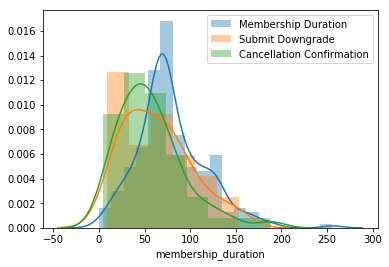

In [9]:
#check when (in the users lifecycle a Downgrade or App Cancelation occurs)
df = event_data_cleaned.select(['membership_duration','userId']).groupBy('userId') \
.max('membership_duration').withColumnRenamed('max(membership_duration)','membership_duration').toPandas()
sns.distplot(df.membership_duration)

df_downgrade = event_data_cleaned.select(['membership_duration','userId']).where(event_data.page == 'Submit Downgrade') \
.groupBy('userId').max('membership_duration').withColumnRenamed('max(membership_duration)','membership_duration').toPandas()
sns.distplot(df_downgrade.membership_duration)
plt.legend(labels=['Membership Duration', 'Submit Downgrade'])

df_cancel = event_data_cleaned.select(['membership_duration','userId']).where(event_data.page == 'Cancellation Confirmation') \
.groupBy('userId').max('membership_duration').withColumnRenamed('max(membership_duration)','membership_duration').toPandas()
sns.distplot(df_cancel.membership_duration)
plt.legend(labels=['Membership Duration', 'Submit Downgrade','Cancellation Confirmation'])

event_data_cleaned.select(avg("membership_duration")).show()

There are activities from 225 users in the provided dataset. The average user is on the platform since 64.3 days. Cancellation of membership (leaving sparkify) or  Downgrade from premium level are both left skewed (especially relative to the average membership duration)
Generally speaking the chance that a new user leave Sparkify is highest in the first few weeks

In [10]:
# split up into activity logs from churned users and users that are still active
df_churned_users = event_data_cleaned.filter(event_data_cleaned.user_churn == 1).orderBy(event_data_cleaned.userId)
df_active_users = event_data_cleaned.filter(event_data_cleaned.user_churn == 0).orderBy(event_data_cleaned.userId)

#Explore User Journey of first user in the set of churned users
df_churned_users.select("page").where(event_data_cleaned.userId == '100009').show(187)

def calculate_page_ratio(df,page_name):
    return df.filter(df.page == page_name).count()/df.count()

# analyse all columns that might differ in these two groups (churned users might have seen a higher number of errors)
print("[churned] error percentage: {}".format(calculate_page_ratio(df_churned_users,'Error'))) #0.0007132667617689016
print("[active] error percentage: {}".format(calculate_page_ratio(df_active_users,'Error'))) #0.00094303227742295
print("[churned] roll advert percentage: {}".format(calculate_page_ratio(df_churned_users,'Roll Advert'))) #0.021554029957203995
print("[active] roll advert percentage: {}".format(calculate_page_ratio(df_active_users,'Roll Advert'))) #0.012713789703802134
print("[churned] settings percentage: {}".format(calculate_page_ratio(df_churned_users,'Settings'))) #0.006018188302425107
print("[active] settings percentage: {}".format(calculate_page_ratio(df_active_users,'Settings'))) #0.00533241887779159
print("[churned] help percentage: {}".format(calculate_page_ratio(df_churned_users,'Help'))) #0.005327211126961484
print("[active] help percentage: {}".format(calculate_page_ratio(df_active_users,'Help'))) #0.005208110077585837
print("[churned] add friend percentage: {}".format(calculate_page_ratio(df_churned_users,'Add Friend'))) #0.014176176890156919
print("[active] add friend percentage: {}".format(calculate_page_ratio(df_active_users,'Add Friend'))) #0.015607184191349823
print("[churned] thumbs down percentage: {}".format(calculate_page_ratio(df_churned_users,'Thumbs Down'))) #0.011055634807417974
print("[active] thumbs down percentage: {}".format(calculate_page_ratio(df_active_users,'Thumbs Down'))) #0.008787346221441126
print("[churned] thumbs up percentage: {}".format(calculate_page_ratio(df_churned_users,'Thumbs Up'))) #0.04143634094151213
print("[active] thumbs up percentage: {}".format(calculate_page_ratio(df_active_users,'Thumbs Up'))) #0.04583136868275537

+---------------+
|           page|
+---------------+
|       NextSong|
|       NextSong|
|      Thumbs Up|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|    Roll Advert|
|    Roll Advert|
|       NextSong|
|    Roll Advert|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|        Upgrade|
|       NextSong|
|       NextSong|
|       Settings|
|       NextSong|
|       NextSong|
|         Logout|
|           Home|
|       NextSong|
|       NextSong|
|    Roll Advert|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|    Roll Advert|
|    Roll Advert|
|       NextSong|
|    Thumbs Down|
|       NextSong|
|       NextSong|
|       NextSong|
|         Logout|
|           Home|
|       NextSong|
|      Thumbs Up|
|       NextSong|
|       NextSong|
|Add to Playlist|
|       NextSong|
|       NextSong|
|         

A significant difference in the two groups can be observed in the number of ads ('Roll Advert') the users see, how the users rate the songs ('Thumps up/down'), how often they visit the 'Settings' page and the number of erros a user experiences. While the churned users saw more ads, rated the songs more negatively (more thumbs down and less thumbs up ) and visited the Settings page more often than the active users the active users actually experienced more errors!

# Feature Engineering
<ol>
  <li>activity: number of total events of the user divided by his/her membership duration, aims to show how active the user is on the app</li>
  <li>total_friends: number of friends the user has on the app</li>
  <li>ads_frequency: how frequent the user sees ads in the app</li>
  <li>level: the level of the user (premium vs. free) represented as a binary value</li>
  <li>membership_duration: number of days past from the users registration to his/her last recorded action in the user log</li>
  <li>gender: the gender of the user represented as a binary value</li>
    <li>rating: the difference of thumbs up and thumbs down issued by the user (the value is negative if the user issued more thumbs down than thumbs up)</li>
</ol>

In [11]:
df_friends = event_data_cleaned.where(event_data_cleaned.page == 'Add Friend') \
                        .groupBy('userId').count().withColumnRenamed('count', 'total_friends')
event_data_cleaned = event_data_cleaned.join(df_friends,"userId","left")


df_ads = event_data_cleaned.where(event_data_cleaned.page == 'Roll Advert') \
                       .groupBy('userId').count().withColumnRenamed('count', 'ads_played')
event_data_cleaned = event_data_cleaned.join(df_ads,"userId","left")


df_thumbs_up = event_data_cleaned.where(event_data_cleaned.page == 'Thumbs Up') \
                       .groupBy('userId').count().withColumnRenamed('count', 'thumbs_up')
event_data_cleaned = event_data_cleaned.join(df_thumbs_up,"userId","left")

df_thumbs_down = event_data_cleaned.where(event_data_cleaned.page == 'Thumbs Down') \
                       .groupBy('userId').count().withColumnRenamed('count', 'thumbs_down')
event_data_cleaned = event_data_cleaned.join(df_thumbs_down,"userId","left")

df_total_events = event_data_cleaned.groupBy('userId').count().withColumnRenamed('count', 'total_events')
event_data_cleaned = event_data_cleaned.join(df_total_events,"userId","left")


In [12]:
#fill the new numeric features with 0 (no recorded action of this type)
event_data_cleaned = event_data_cleaned.fillna(0,subset = ['ads_played','total_friends','thumbs_up','thumbs_down'])
#show new features
event_data_cleaned.select (['userId','ads_played','total_friends','thumbs_up','thumbs_down']).dropDuplicates().show()

+------+----------+-------------+---------+-----------+
|userId|ads_played|total_friends|thumbs_up|thumbs_down|
+------+----------+-------------+---------+-----------+
|100010|        52|            4|       17|          5|
|200002|         7|            4|       21|          6|
|   125|         1|            0|        0|          0|
|   124|         4|           74|      171|         41|
|    51|         0|           28|      100|         21|
|     7|        16|            1|        7|          1|
|    15|         1|           31|       81|         14|
|    54|        47|           33|      163|         29|
|   155|         8|           11|       58|          3|
|100014|         2|            6|       17|          3|
|   132|         2|           41|       96|         17|
|   154|        10|            3|       11|          0|
|   101|         8|           29|       86|         16|
|    11|        39|            6|       40|          9|
|   138|        17|           41|       95|     

In [13]:
#calculate frequency of ad impressions instead of total count
event_data_cleaned = event_data_cleaned.withColumn('ads_frequency', \
                                              (event_data_cleaned['ads_played'] / event_data_cleaned['total_events']))

In [14]:
#calculate the rating by subtracting the number of given thumbs_down from the number of thumbs up
event_data_cleaned = event_data_cleaned.withColumn('rating', \
                                              (event_data_cleaned['thumbs_up'] - event_data_cleaned['thumbs_down']))

In [15]:
print(event_data_cleaned.count())
event_data_cleaned.show()

278154
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-----+----------+-------------------+-------------+----------+---------+-----------+------------+-------------------+------+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|churn|user_churn|membership_duration|total_friends|ads_played|thumbs_up|thumbs_down|total_events|      ads_frequency|rating|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-----+----------+-------------------+-------------+----------+---------+--

In [16]:
event_data_cleaned_pandas = event_data_cleaned.toPandas()

In [17]:
event_data_cleaned_pandas = event_data_cleaned_pandas.drop_duplicates(subset=['userId'],keep='last')

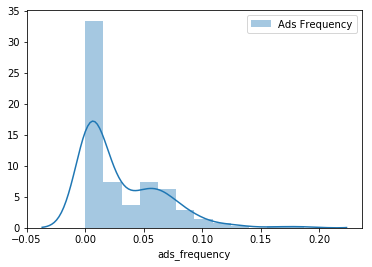

In [18]:
# check distribution of new columns
sns.distplot(event_data_cleaned_pandas.ads_frequency)
plt.legend(labels=['Ads Frequency'])

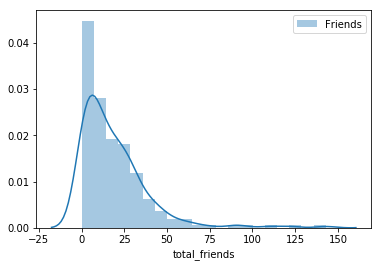

In [19]:
# check distribution of new columns
sns.distplot(event_data_cleaned_pandas.total_friends)
plt.legend(labels=['Friends'])

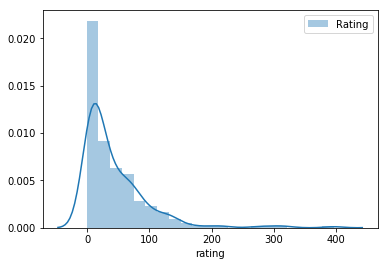

In [20]:
# check distribution of new columns
sns.distplot(event_data_cleaned_pandas.rating)
plt.legend(labels=['Rating'])

In [21]:
#use entry with the highest membership duration = last user state before churning/not churning
user_data_logs = event_data_cleaned.select('userId','gender','level','user_churn','membership_duration','ts','total_friends','ads_frequency','rating','total_events').dropDuplicates()

#https://stackoverflow.com/questions/48829993/groupby-column-and-filter-rows-with-maximum-value-in-pyspark
user_data = user_data_logs.withColumn("row", row_number().over(Window.partitionBy('UserId').orderBy(col("ts").desc())))\
  .filter(col("row") == 1).drop("row")

In [22]:
user_data.show()
user_data = user_data.withColumn("gender", when(col("gender") == "M", 0).otherwise(when(col("gender") =='F', 1).cast("int")))
user_data = user_data.withColumn("level", when(col("level") == "free", 0).otherwise(when(col("level") =='paid', 1).cast("int")))
user_data = user_data.drop('ts')
user_data = user_data.select(*(col(c).cast("float").alias(c) for c in user_data.columns))
user_data = user_data.withColumnRenamed('user_churn','label')
user_data = user_data.withColumn("label",user_data.label.cast('integer'))
user_data = user_data.withColumn('activity',(user_data['total_events'] / user_data['membership_duration']))
user_data = user_data.fillna(0,subset = ['activity'])
user_data.orderBy('activity').show()

+------+------+-----+----------+-------------------+-------------+-------------+--------------------+------+------------+
|userId|gender|level|user_churn|membership_duration|           ts|total_friends|       ads_frequency|rating|total_events|
+------+------+-----+----------+-------------------+-------------+-------------+--------------------+------+------------+
|100010|     F| free|         0|                 55|1542823952000|            4| 0.13648293963254593|    12|         381|
|200002|     M| paid|         0|                 70|1542324354000|            4|0.014767932489451477|    15|         474|
|   125|     M| free|         1|                 71|1539318918000|            0| 0.09090909090909091|     0|          11|
|   124|     F| paid|         0|                131|1543590766000|           74|8.290155440414508E-4|   130|        4825|
|    51|     M| paid|         1|                 19|1539761972000|           28|                 0.0|    79|        2464|
|     7|     M| free|   

In [23]:
#user_data_final.write.json('sparkify_user_data2.json')

# Modeling


In [24]:
def train_model(data,classifier,params,feature_names):
    """ Fits classifier to given data using corss validation appraoch
    Args:
      data (DataFrame): data used to train the classifier
      classifier (pyspark.ml.classification): PySpark classifier object
      params (ParamGrid): parameter grid used in the cross validation approach fo fine tune the model
      feature_names (list): names of all features of the dataframe that should be used for training
    """
    assembler = VectorAssembler(inputCols = feature_names, outputCol='numerical_features')    
    scaler = StandardScaler(inputCol="numerical_features", outputCol="features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])
  

    crossval= CrossValidator(estimator=pipeline,  
                             estimatorParamMaps=params,
                             evaluator=BinaryClassificationEvaluator(), 
                             numFolds=3
                             )
    start = time.time()
    # fit the cross validation linear support vector machine model
    model = crossval.fit(training) 
    end = time.time()
    print(f'Model fitting took {end-start} seconds')
    return model

In [25]:
def evaluate_model(results):
    """ Method for evaluation the results of any model. Calculates f1_score and accuracy using the models predictions
    Args:
      results (DataFrame): dataframe containing the predictions of the model and the original labels 
    """
    correct_predictions = (results.filter(results.label == results.prediction).count())
    total_predictions = (results.count())
    churn_predictions = (results.filter( '1.0' == results.prediction).count())
    results_pd = results.toPandas()
    print('f1_score: {}'.format(f1_score(results_pd.label.values,results_pd.prediction.values)))
    print('accuracy: {}'.format(accuracy_score(results_pd.label.values,results_pd.prediction.values)))
    print('predicted user churn ration: {}'.format(churn_predictions/total_predictions))

In [27]:
(training, test) = user_data.randomSplit([0.70, 0.30], seed=42)
#show distribution of user churn in test and training data to get an idea of the baseline for our model eg.
#baseling = performance of model thatl always guesses 0 = user does not churn
print(training.filter(col('label') == 0).count()/training.count())
print(test.filter(col('label') == 0).count()/test.count())

KeyboardInterrupt: 

In [ ]:
# define names of columnes the model should use for learning
feature_names = ['gender','ads_frequency','level','membership_duration','rating','total_friends','activity']

In [ ]:
#Baseline
base_model = test.withColumn('prediction', F.lit(0))
evaluate_model(base_model)

In [ ]:
#Logistic Regression 
lr_model = LogisticRegression() 
params =ParamGridBuilder()\
.addGrid(lr_model.maxIter, [10,50,100,150]) \
.build()

lr_model_result = train_model(training,lr_model,params,feature_names)
evaluate_model(lr_model_result.transform(test))

In [ ]:
#Gradient Boost Classifier
gbc_model = GBTClassifier() 
params = ParamGridBuilder() \
                  .addGrid(gbc_model.maxIter ,[20, 100]) \
                  .addGrid(gbc_model.maxDepth, [5, 10]) \
                  .build()


gbc_model_result = train_model(training,gbc_model,params,feature_names)
evaluate_model(gbc_model_result.transform(test))

In [ ]:
#Random Forst Classifier
rf_model = RandomForestClassifier() 
params = ParamGridBuilder() \
                  .addGrid(rf_model.numTrees ,[20, 40]) \
                  .addGrid(rf_model.maxDepth, [5, 10]) \
                  .build()
rf_model_result = train_model(training,rf_model,params,feature_names)
evaluate_model(rf_model_result.transform(test))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.